<a href="https://colab.research.google.com/github/majidebraa/AnomalyDetection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1-Import libraries**

In [ ]:
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model
from keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from keras import regularizers
from keras import losses
from numpy import vstack

# **2-Preprocessing dataset**

In [ ]:
log = '/content/webLog.csv'
log = pd.read_csv(log)
log = log.drop(log.columns[1], axis=1)
samples = []
for row in log.iterrows():
    index, data = row
    samples.append(data.tolist())

max_words = 20000
maxlen = 3

# **3-Tokenize and padding values**

In [ ]:
# Tokenize values.
tokenizer = Tokenizer(num_words=max_words, lower=False)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 269 unique tokens.


# **4-Split data into training and test set**

In [ ]:
training_samples = int(len(samples) * 0.80)
test_samples = int(len(samples) * 0.20)

x_train = data[:training_samples]
x_test = data[training_samples: training_samples + test_samples]

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
print("Training data shape:", x_train.shape)
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
print("Test data shape:", x_test.shape)

Training data shape: (8628, 1, 3)
Test data shape: (2157, 1, 3)


# **5- Creat model, fit and results**

In [ ]:
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
encoded = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
encoded = LSTM(4, activation='relu', return_sequences=False)(encoded)
encoded = RepeatVector(x_train.shape[1])(encoded)
decoded = LSTM(4, activation='relu', return_sequences=True)(encoded)
decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(x_train.shape[2]))(decoded)    
autoencoder = Model(inputs=inputs, outputs=decoded)


autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss=losses.mean_squared_error)

# Train model.
history = autoencoder.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test),
        shuffle=True
        )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1280      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

# **6- Reconstruction error for autoencoder** 

In [ ]:
# Combined x and x_test.
new_x = vstack([x_train, x_test])

predictions = autoencoder.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': np.sum(mse, axis=1)})

# Set threshold at the 99th quantile.
threshold = error_df.quantile(0.99)

error_df.describe()

,reconstruction_error
count,10785.000000
mean,0.254760
std,1.412138
min,0.000213
25%,0.011091
50%,0.036236
75%,0.120585
max,48.786391


In [ ]:
error_df

,reconstruction_error
0,0.050193
1,0.020569
2,0.018247
3,0.088698
4,1.958329
...,...
10780,0.097668
10781,0.010170
10782,0.015539
10783,0.059488


(array([1.073e+04, 2.900e+01, 1.000e+01, 1.000e+01, 5.000e+00, 0.000e+00,
        1.000e+00]),
 array([2.12782741e-04, 6.96966687e+00, 1.39391210e+01, 2.09085750e+01,
        2.78780291e+01, 3.48474832e+01, 4.18169373e+01, 4.87863914e+01]),
 <a list of 7 Patch objects>)

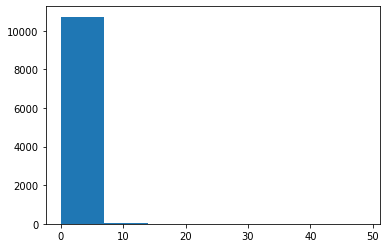

In [ ]:
# Reconstruction error binned and plotted.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(error_df.reconstruction_error.values, bins=7)

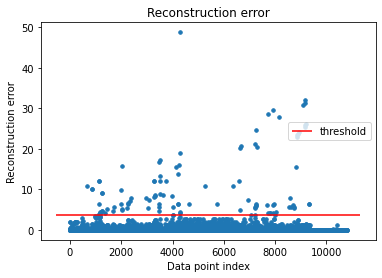

In [ ]:
# Plot reconstruction error vs the data
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# **7- Print anomalies requests**

In [ ]:
# Output anomalies.
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > int(threshold):
        index_list.append(index)

output = []    
for x in index_list:
    output.append(new_x[x])
print(len(output))
for x in output:
    for key, value in word_index.items():
        if value == x[0][2]:
            print(key)
        if value == x[0][1]:
            print(key)
        if value == x[0][0]:
            print(key)
    print('----------------------------------')

118
302
10.131.2.1
GET / HTTP/1.0
----------------------------------
10.131.2.1
GET /js/vendor/moment.min.js HTTP/1.1
206
----------------------------------
10.131.2.1
GET /js/vendor/moment.min.js HTTP/1.1
206
----------------------------------
200
10.131.0.1
GET /profile.php?user=moshiur_cse15 HTTP/1.1
----------------------------------
200
10.131.0.1
GET /allsubmission.php?name=moshiur_cse15 HTTP/1.1
----------------------------------
200
10.131.0.1
GET /showcode.php?id=286&nm=Rakib_1603065 HTTP/1.1
----------------------------------
200
10.128.2.1
GET /showcode.php?id=287&nm=Riyal_RUET HTTP/1.1
----------------------------------
200
10.128.2.1
GET /showcode.php?id=288&nm=Riyal_RUET HTTP/1.1
----------------------------------
10.131.2.1
GET /js/chart.min.js HTTP/1.1
206
----------------------------------
10.131.2.1
GET /js/chart.min.js HTTP/1.1
206
----------------------------------
10.129.2.1
GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1
206
----------------------------------
200
10

# **8- Plot Accuracy and Loss for model**

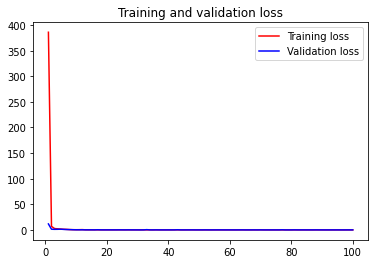

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1 , len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()